In [1]:
!pip3 install pandas numpy matplotlib tensorflow keras chardet




[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python3.11 -m pip install --upgrade pip


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [3]:
import os
csv_file = "furniture_data.csv"
folder = "Furniture_Data"

data = []
for furniture_type in os.listdir(folder):
    if not os.path.isdir(os.path.join(folder, furniture_type)):
        continue
    for style in os.listdir(os.path.join(folder, furniture_type)):
        if not os.path.isdir(os.path.join(folder, furniture_type, style)):
            continue
        for image in os.listdir(os.path.join(folder, furniture_type, style)):
            data.append([furniture_type, style, os.path.join(folder, furniture_type, style, image)])

with open(csv_file, "w") as f:
    f.write("type,style,image_path\n")
    for row in data:
        f.write(",".join(row) + "\n")

In [4]:
df = pd.read_csv(csv_file)
df.head()


,type,style,image_path
0,tables,Eclectic,Furniture_Data/tables/Eclectic/4029eclectic-si...
1,tables,Eclectic,Furniture_Data/tables/Eclectic/4107eclectic-ni...
2,tables,Eclectic,Furniture_Data/tables/Eclectic/3885eclectic-si...
3,tables,Eclectic,Furniture_Data/tables/Eclectic/4040eclectic-si...
4,tables,Eclectic,Furniture_Data/tables/Eclectic/4171eclectic-co...


In [ ]:

df['type'].value_counts()

In [16]:
df = pd.read_csv('furniture_data.csv')

In [23]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, shuffle=True)
train_df.shape, test_df.shape

((72067, 3), (18017, 3))

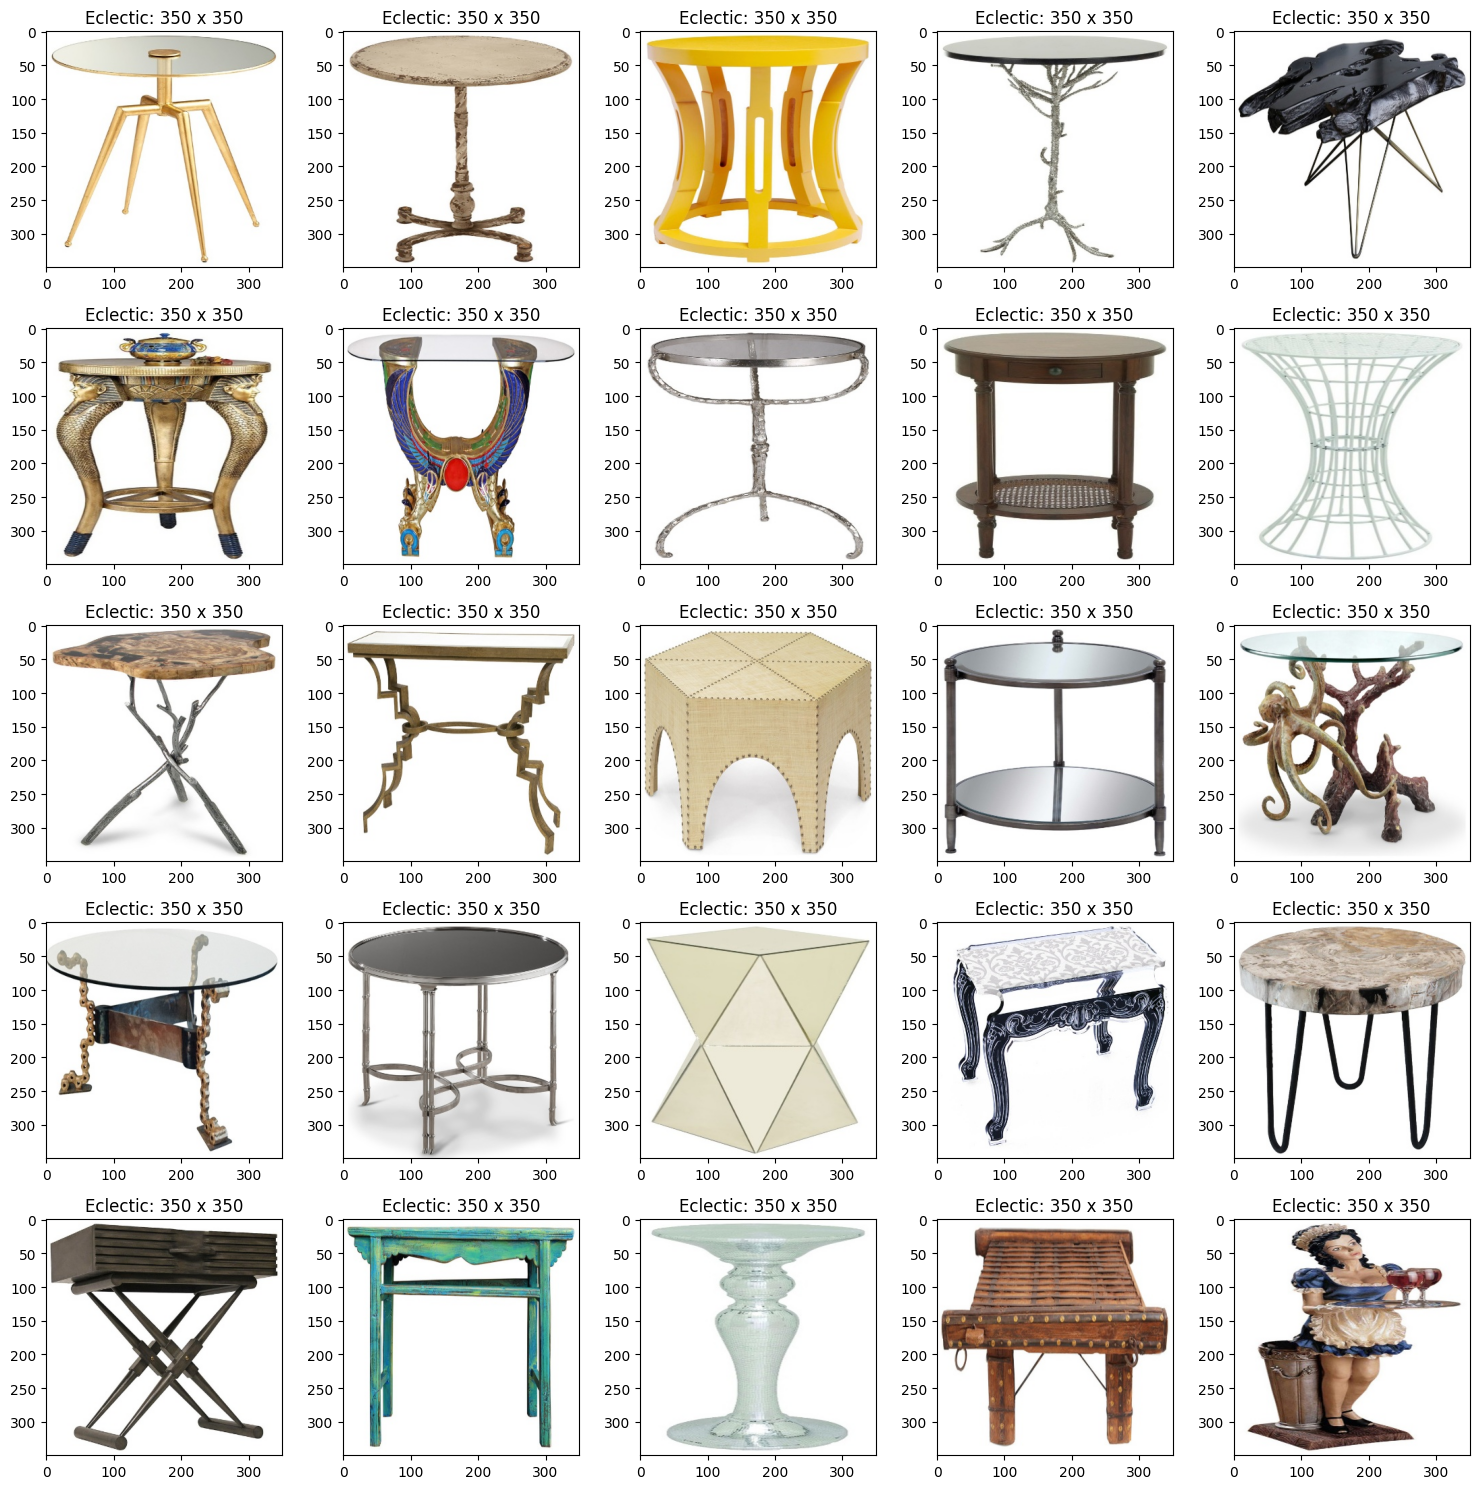

In [27]:
from PIL import Image
fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(15, 15))

for i, ax in enumerate(axes.flat):
    image_overview = Image.open(df.loc[i, "image_path"])
    ax.imshow(image_overview)
    width, height = image_overview.size
    ax.set_title(df.loc[i, "style"] + ": {} x {}".format(width, height))
plt.tight_layout()
plt.show()

In [30]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img

train_datagen = ImageDataGenerator( rescale=1/255.0,
                                    rotation_range=40,
                                    width_shift_range=0.05,
                                    height_shift_range=0.05,
                                    shear_range=0.2,
                                    zoom_range=0.1,
                                    horizontal_flip=True,
                                    brightness_range=[0.6, 1.2],
                                    fill_mode='nearest',
                                    validation_split=0.15,                      
                                    )

test_datagen = ImageDataGenerator(rescale=1/255.0)


Found 72066 validated image filenames belonging to 6 classes.
Found 18016 validated image filenames belonging to 6 classes.


In [36]:

train_generator = train_datagen.flow_from_dataframe(
    train_df,
    x_col='image_path',
    y_col='type',
    target_size=(224, 224),  # Adjust based on your needs
    class_mode='categorical',
    subset='training',
    seed=42,
    shuffle=True,
    batch_size=32)

val_generator = train_datagen.flow_from_dataframe(
    train_df,
    x_col='image_path',
    y_col='type',
    target_size=(224, 224),
    class_mode='categorical',
    subset='validation',
    seed=42,
    shuffle=True,
    batch_size=32)

test_generator = test_datagen.flow_from_dataframe(
    test_df,
    x_col='image_path',
    y_col='type',
    target_size=(224, 224),
    class_mode='categorical',
    shuffle=False,
    batch_size=32)



Found 61257 validated image filenames belonging to 6 classes.
Found 10809 validated image filenames belonging to 6 classes.
Found 18016 validated image filenames belonging to 6 classes.


In [51]:
import tensorflow as tf
import ssl
from tensorflow.keras.callbacks import EarlyStopping
ssl._create_default_https_context = ssl._create_unverified_context

base_model = tf.keras.applications.ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze the base model

model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(len(train_generator.class_indices), activation='softmax')
])

early_stopping_callback = EarlyStopping(
    monitor='val_accuracy',
    patience = 10,
    restore_best_weights = True,
    verbose = 1,
    min_delta = 0.0001,
)

optimization = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimization, loss='categorical_crossentropy', metrics=['accuracy'])

In [52]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=5,
    batch_size=32,
    callbacks=[early_stopping_callback],
)

Epoch 1/5
1915/1915 ━━━━━━━━━━━━━━━━━━━━ 1717s 894ms/step - accuracy: 0.4421 - loss: 1.4346 - val_accuracy: 0.5613 - val_loss: 1.1463
Epoch 2/5
1915/1915 ━━━━━━━━━━━━━━━━━━━━ 1791s 934ms/step - accuracy: 0.5414 - loss: 1.1988 - val_accuracy: 0.5574 - val_loss: 1.1524
Epoch 3/5
1915/1915 ━━━━━━━━━━━━━━━━━━━━ 1917s 1s/step - accuracy: 0.5584 - loss: 1.1596 - val_accuracy: 0.5972 - val_loss: 1.0458
Epoch 4/5
1915/1915 ━━━━━━━━━━━━━━━━━━━━ 2145s 1s/step - accuracy: 0.5712 - loss: 1.1175 - val_accuracy: 0.6199 - val_loss: 1.0345
Epoch 5/5
1915/1915 ━━━━━━━━━━━━━━━━━━━━ 1741s 909ms/step - accuracy: 0.5823 - loss: 1.1007 - val_accuracy: 0.6262 - val_loss: 0.9804
Restoring model weights from the end of the best epoch: 5.


In [60]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
num_classes = len(train_generator.class_indices)

# VGGNet19
base_model = tf.keras.applications.VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze the base model

model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(len(train_generator.class_indices), activation='softmax')
])

early_stopping_callback = EarlyStopping(
    monitor='val_accuracy',
    patience=10,
    restore_best_weights=True,
    verbose=1,
    min_delta=0.0001,
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=5,
    min_lr=0.00001,
    verbose=1
)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=5,  # Increased number of epochs
    batch_size=32,
    callbacks=[early_stopping_callback, reduce_lr],
)




Epoch 1/5
1915/1915 ━━━━━━━━━━━━━━━━━━━━ 7393s 4s/step - accuracy: 0.7238 - loss: 0.8538 - val_accuracy: 0.8213 - val_loss: 0.5149 - learning_rate: 0.0010
Epoch 2/5
1915/1915 ━━━━━━━━━━━━━━━━━━━━ 9721s 5s/step - accuracy: 0.8279 - loss: 0.4981 - val_accuracy: 0.8320 - val_loss: 0.4496 - learning_rate: 0.0010
Epoch 3/5
1915/1915 ━━━━━━━━━━━━━━━━━━━━ 7135s 4s/step - accuracy: 0.8334 - loss: 0.4744 - val_accuracy: 0.8359 - val_loss: 0.4658 - learning_rate: 0.0010
Epoch 4/5
1915/1915 ━━━━━━━━━━━━━━━━━━━━ 7030s 4s/step - accuracy: 0.8412 - loss: 0.4547 - val_accuracy: 0.8405 - val_loss: 0.4609 - learning_rate: 0.0010
Epoch 5/5
1915/1915 ━━━━━━━━━━━━━━━━━━━━ 7049s 4s/step - accuracy: 0.8422 - loss: 0.4478 - val_accuracy: 0.8576 - val_loss: 0.3987 - learning_rate: 0.0010
Restoring model weights from the end of the best epoch: 5.


In [64]:
test_loss, test_accuracy = model.evaluate(test_generator)
test_loss, test_accuracy


563/563 ━━━━━━━━━━━━━━━━━━━━ 1954s 3s/step - accuracy: 0.9125 - loss: 0.2598


(0.2744894325733185, 0.9077486395835876)

In [66]:
model.save('VGG.keras')